# PRODUCTO FINAL
#### CURSO: FUNDAMENTOS DE CIENCIA DE DATOS

Descripción del problema: [Más información](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

# IMPORTAR LIBRERIAS

In [206]:
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import scipy.stats as stats
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 90)

# CARGAR INFORMACIÓN INICIAL

In [207]:
datos_entrenamiento = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
datos_predecir = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')
ejemplo_csv = pd.read_csv('./house-prices-advanced-regression-techniques/sample_submission.csv')

# COMPRESIÓN DE LOS DATOS

## IDENTIFICAR CORRELACIONES FUERTES (>=0.5)

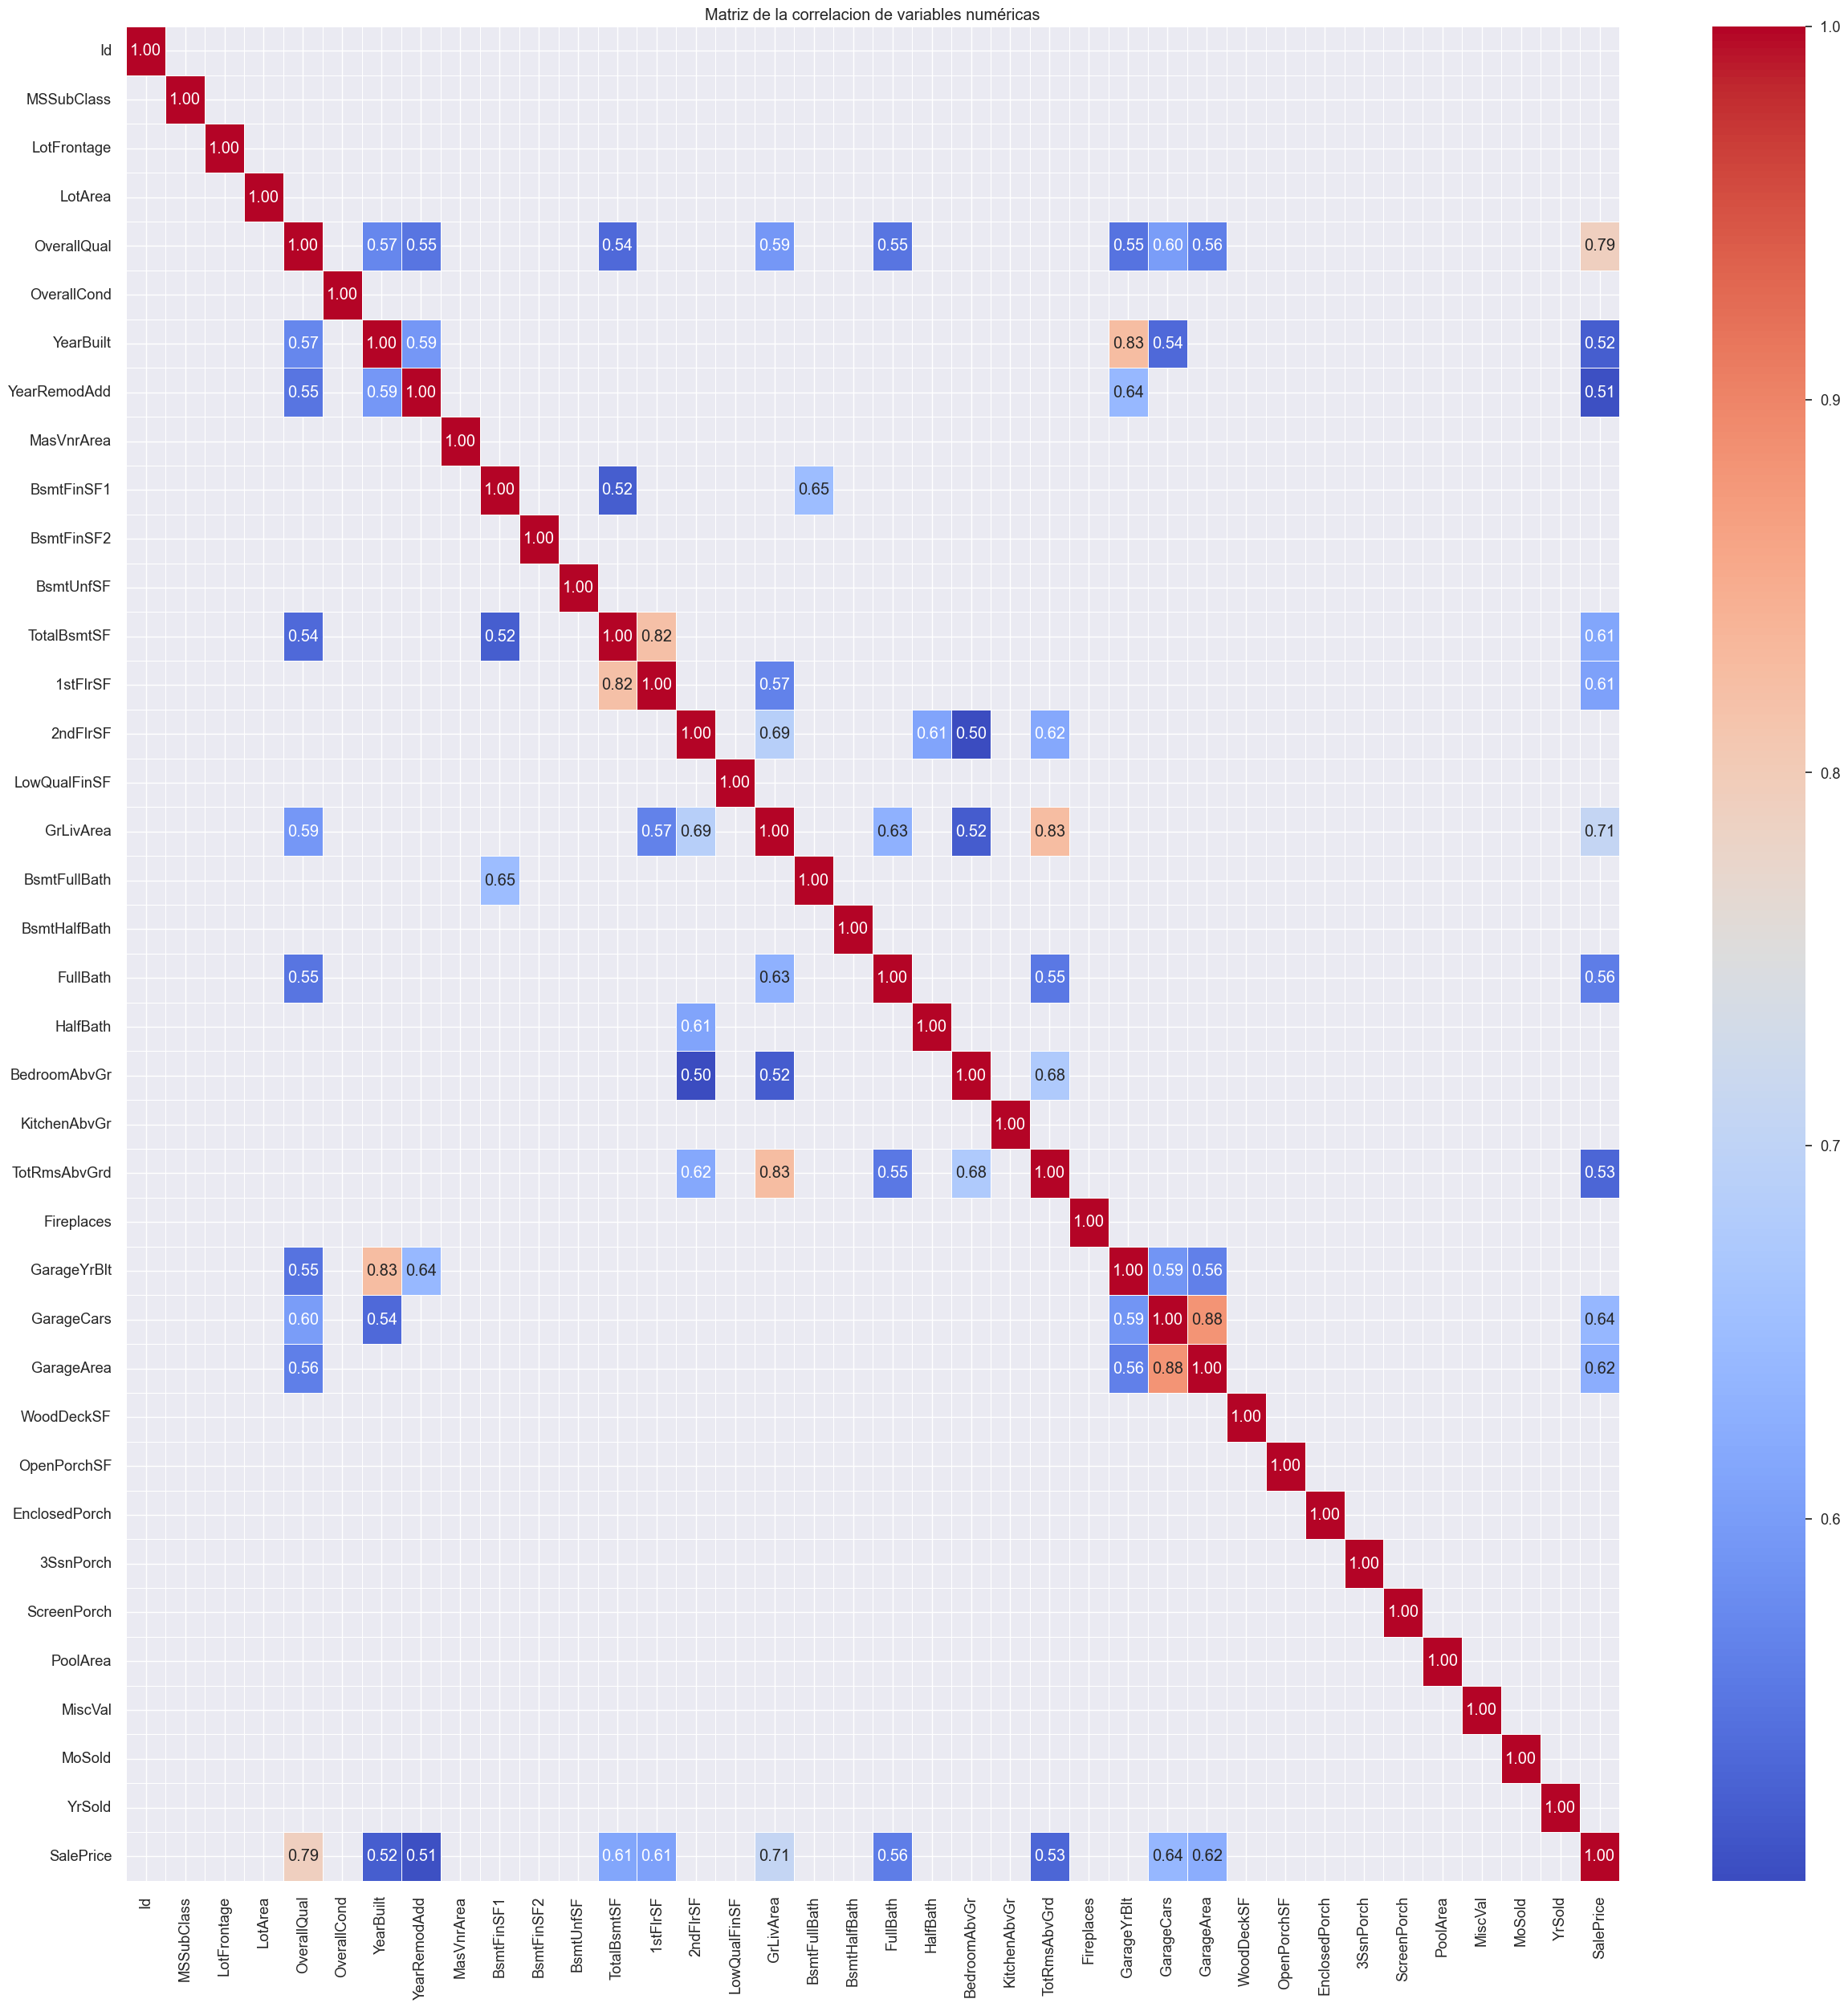

In [208]:
corr_matrix = datos_entrenamiento.select_dtypes(np.number).corr()
# Aplicar el filtro para obtener correlaciones mayores o iguales a 0.5
filtered_corr_matrix = corr_matrix[(corr_matrix >= 0.5) | (corr_matrix <= -0.5)]
# Heatmap of correlations
plt.figure(figsize=(30, 30))
sns.heatmap(filtered_corr_matrix, cmap='coolwarm', annot=True, linewidths=.5, fmt=".2f")
plt.title('Matriz de la correlacion de variables numéricas')
plt.show()

## IDENTIFICAR TENDENCIAS DE LAS VARIABLES

Text(0.5, 1.0, 'YrSold vs SalePrice')

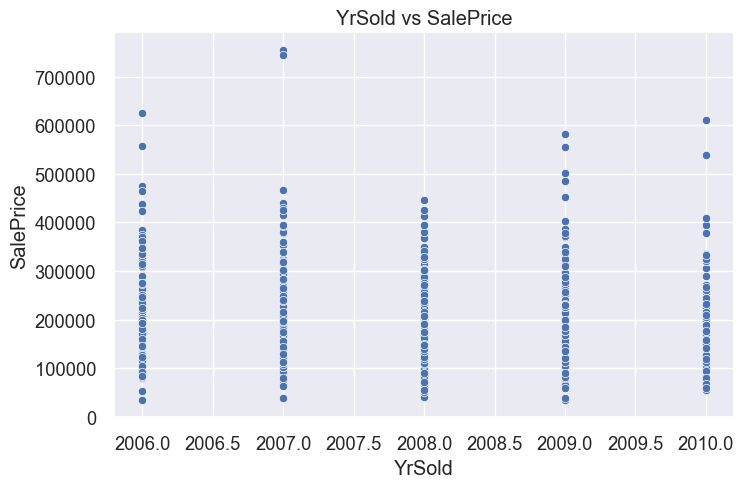

In [209]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.scatterplot(x="YrSold", y="SalePrice", data=datos_entrenamiento)
plt.title("YrSold vs SalePrice")

# PREPARACIÓN DE LOS DATOS

## UNIFICAR DATOS

In [210]:
variable_objetivo = datos_entrenamiento['SalePrice']
datos_predecir_ids = datos_predecir['Id']

#Unir los datos de entramiento con los datos que sirven para predecir
datos_entrenamiento1 = datos_entrenamiento.drop(['Id', 'SalePrice'], axis=1)
datos_predecir1 = datos_predecir.drop('Id', axis=1)

datos_total1 = pd.concat([datos_entrenamiento1, datos_predecir1], axis=0).reset_index(drop=True)
datos_total1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Un

## IDENTIFICAR VARIABLES NUMERICAS CON NAN

Text(0.5, 1.0, 'Todas la variables numericas que tienen valores nulos')

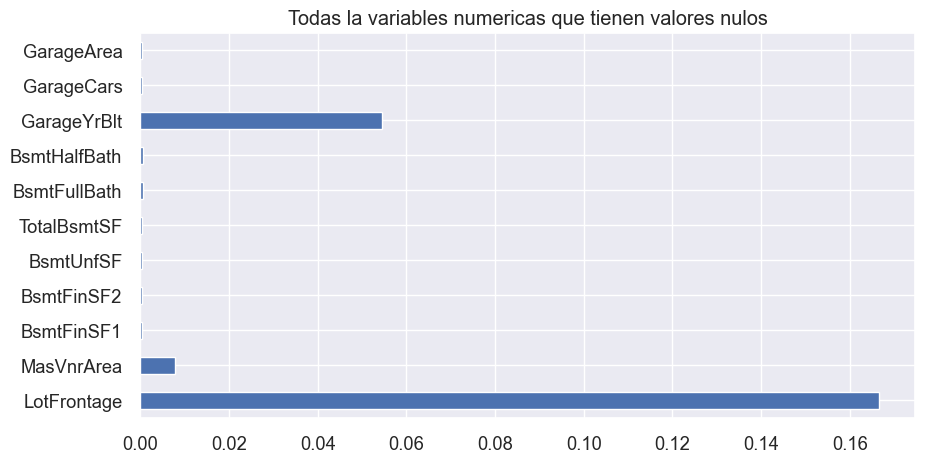

In [211]:
col_nan2 = datos_total1.select_dtypes(np.number).isna().sum() / datos_total1.shape[0]
col_nan2
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.2)
col_nan2[col_nan2 > 0.00001].plot(kind = "barh")
plt.title("Todas la variables numericas que tienen valores nulos")


## IDENTIFICAR VARIABLES CATEGÓRICAS CON NAN

Text(0.5, 1.0, 'Todas la variables categoricas que tienen valores nulos')

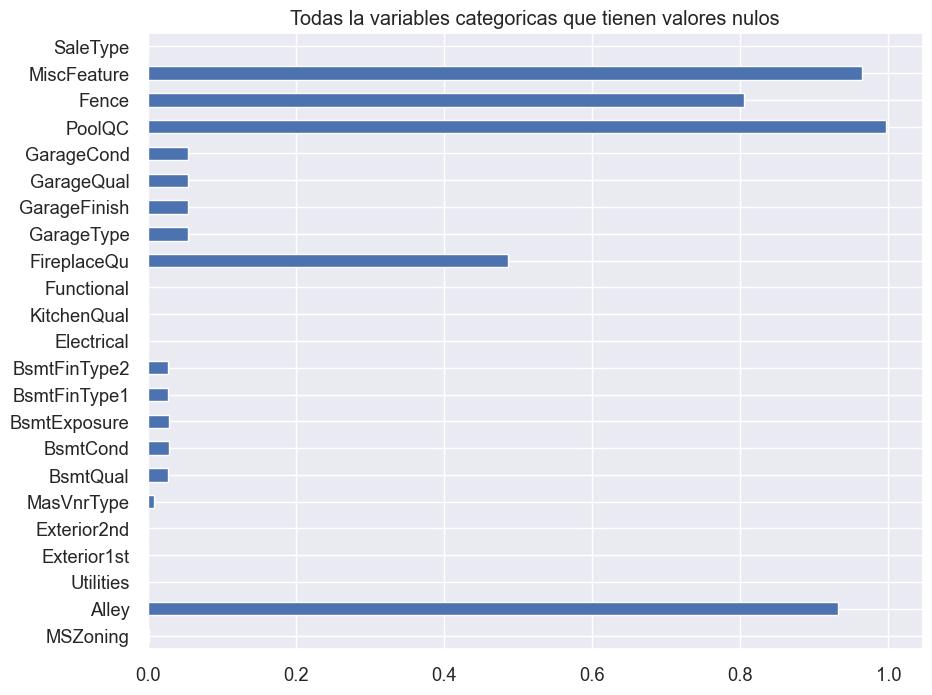

In [212]:
col_nan = datos_total1.select_dtypes('object').isna().sum() / datos_total1.shape[0]
col_nan
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.00001].plot(kind = "barh")
plt.title("Todas la variables categoricas que tienen valores nulos")

TODAS LAS VARIABLES CATEGÓRICAS

In [213]:
datos_total1.select_dtypes('object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

LAS VARIABLES CATEGÓRICAS CON Nan

In [214]:
datos_total1.select_dtypes('object').loc[:,datos_total1.isna().sum()>0].columns

Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

TODAS LAS VARIABLES NUMÉRICAS

In [215]:
datos_total1.select_dtypes(np.number).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

TODAS LAS VARIABLES NUMÉRICAS CON Nan

In [216]:

datos_total1.select_dtypes(np.number).loc[:,datos_total1.isna().sum()>0].columns

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

## LIMPIEZA DE LOS DATOS

In [217]:
datos_total2 = datos_total1.copy()

TRANSFORMAR TIPOS DE DATOS

In [218]:
datos_total2['MSSubClass'] = datos_total2['MSSubClass'].astype(str)

### COMPLETAR DATA DE VARIABLES CATEGÓRICAS

In [219]:
# TODAS LA VARIABLES CATEGORICAS QUE TIENE COMO OPCION NA EN SU DESCRIPCIÓN Y COMO COMO DATO TIENEN ASIGNADO NA COMPLETAMOS CON None
for column in [
    'Alley', # tipo de callejon
    'BsmtQual', # Evalúa la altura del sótano.
    'BsmtCond',  # Evalúa el estado general del sótano.
    'BsmtExposure', # Se refiere a paredes a nivel de jardín o de salida.
    'BsmtFinType1', # 
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    datos_total2[column] = datos_total2[column].fillna("None")

# TODAS LA VARIABLES CATEGORICAS QUE NO TIENE COMO OPCION NA, COMPLETAMOS CON LA MODA.
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    datos_total2[column] = datos_total2[column].fillna(datos_total2[column].mode()[0])

In [220]:
datos_total3 = datos_total2.copy()

### COMPLETAR DATA DE VARIABLES NUMÉRICAS

ALGORITMO KNN PARA PREDECIR LOS DATOS NUMERICOS

In [221]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [222]:
for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
]:
    datos_total3 = knn_impute(datos_total3, column)

In [223]:
datos_total31 = datos_total3.copy()

In [224]:
datos_total31["SqFtPerRoom"] = datos_total31["GrLivArea"] / (datos_total31["TotRmsAbvGrd"] +
                                                       datos_total31["FullBath"] +
                                                       datos_total31["HalfBath"] +
                                                       datos_total31["KitchenAbvGr"])

datos_total31['Total_Home_Quality'] = datos_total31['OverallQual'] + datos_total31['OverallCond']

datos_total31['Total_Bathrooms'] = (datos_total31['FullBath'] + (0.5 * datos_total31['HalfBath']) +
                               datos_total31['BsmtFullBath'] + (0.5 * datos_total31['BsmtHalfBath']))

datos_total31["HighQualSF"] = datos_total31["1stFlrSF"] + datos_total31["2ndFlrSF"]

In [225]:
datos_total4 = datos_total31.copy()

## TRANSFORMACIÓN DE LOS DATOS

### APLICAR TRANFORMACIÓN LOGARITMICA 

In [226]:
skew_df = pd.DataFrame(datos_total4.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Sesgo'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(datos_total4[feature]))
skew_df['Sesgo Absoluto'] = skew_df['Sesgo'].apply(abs)
skew_df['Sesgado'] = skew_df['Sesgo Absoluto'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Sesgo,Sesgo Absoluto,Sesgado
0,LotFrontage,1.340751,1.340751,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True
5,YearRemodAdd,-0.451020,0.451020,False
6,MasVnrArea,2.603682,2.603682,True
7,BsmtFinSF1,1.425516,1.425516,True
8,BsmtFinSF2,4.146111,4.146111,True
9,BsmtUnfSF,0.919322,0.919322,True


In [227]:
for column in skew_df.query("Sesgado == True")['Feature'].values:
    datos_total4[column] = np.log1p(datos_total4[column])

In [228]:
datos_total4['MoSold'].unique()

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6], dtype=int64)

Transformación especial para datos cíclicos como fecha.

In [229]:
datos_total31['MoSold'] = (-np.cos(0.5236 * datos_total4['MoSold']))

Aplicar transformación logaritmica al precio.

<Axes: >

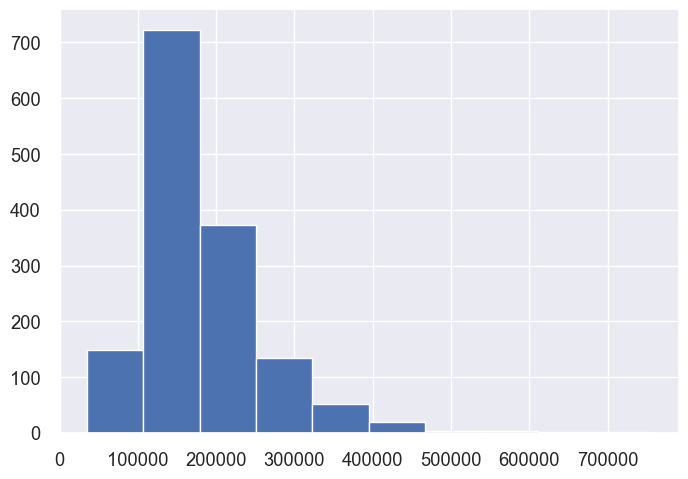

In [230]:
variable_objetivo.hist()

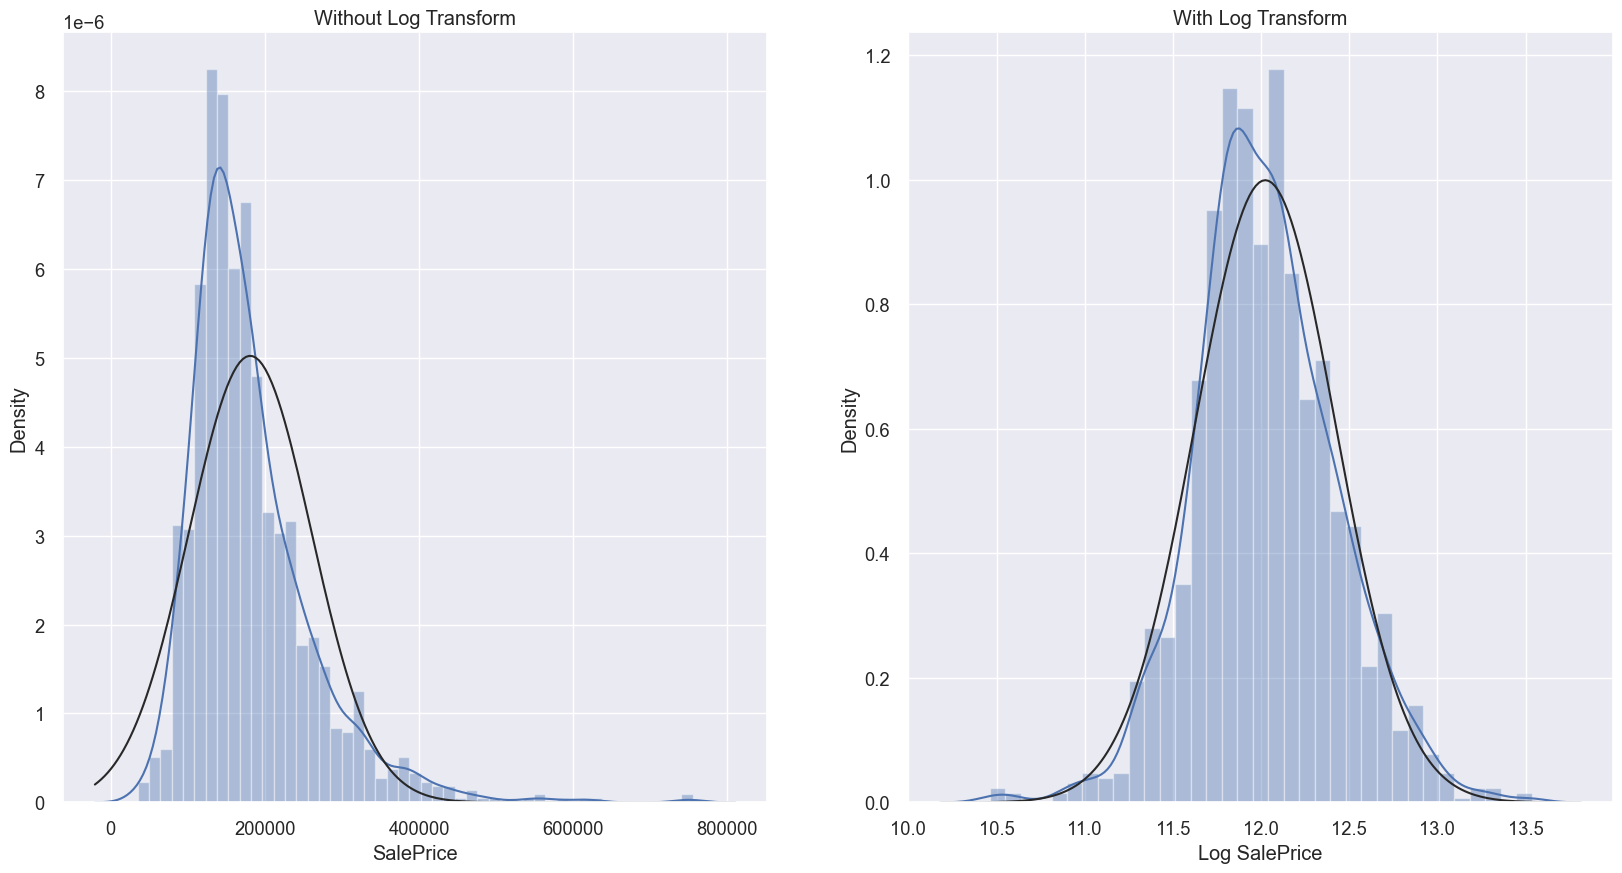

In [231]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(variable_objetivo, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(variable_objetivo), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

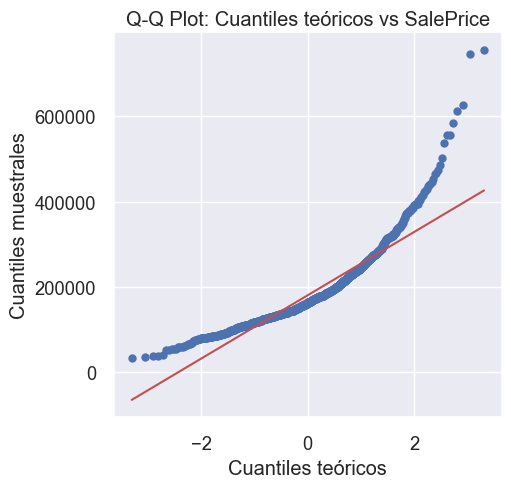

In [232]:
#Cuantiles teóricos con el  SalePrice
plt.figure(figsize=(5, 5))
stats.probplot(variable_objetivo, dist="norm", plot=plt)
plt.title('Q-Q Plot: Cuantiles teóricos vs SalePrice')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles muestrales')
plt.grid(True)
plt.show()



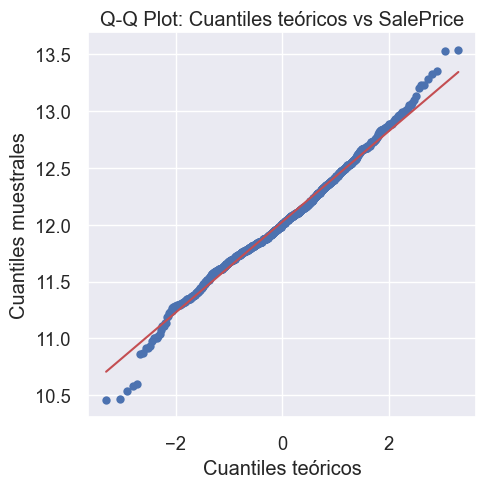

In [233]:
#Cuantiles teóricos con el  SalePrice aplicando logaritmo.
plt.figure(figsize=(5, 5))
stats.probplot(np.log(variable_objetivo), dist="norm", plot=plt)
plt.title('Q-Q Plot: Cuantiles teóricos vs SalePrice')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles muestrales')
plt.grid(True)
plt.show()

In [234]:
log_variable_objetivo = np.log(variable_objetivo)
log_variable_objetivo

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

In [235]:
datos_total5 = datos_total4.copy()

###  APLICAR CODIFICACIÓN CATEGÓRICA

In [236]:
datos_total5 = pd.get_dummies(datos_total5)
datos_total5

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functio

In [237]:
datos_total6 = datos_total5.copy()

### ESCALANDO DATOS

In [238]:
scaler = StandardScaler()
scaler.fit(datos_total6)
datos_total6 = pd.DataFrame(scaler.transform(datos_total6), index=datos_total6.index, columns=datos_total6.columns)
datos_total6

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functio

In [239]:
datos_total7 = datos_total6.copy()

### SEPARAR INFORMACIÓN

In [240]:
datos_entrenamiento_final = datos_total7.loc[:datos_entrenamiento.index.max(), :].copy()
datos_predecir_final = datos_total7.loc[datos_entrenamiento.index.max() + 1:, :].reset_index(drop=True).copy()

# MODELADO

## EVALUACIÓN DE MODELOS

In [241]:
_ = setup(data=pd.concat([datos_entrenamiento_final, log_variable_objetivo], axis=1), target='SalePrice')

,Description,Value
0,Session id,4420
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 322)"
4,Transformed data shape,"(1460, 322)"
5,Transformed train set shape,"(1021, 322)"
6,Transformed test set shape,"(439, 322)"
7,Numeric features,321
8,Preprocess,True
9,Imputation type,simple


Comparar modelos

In [242]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0809,0.0154,0.1219,0.9009,0.0094,0.0068,2.6350
br,Bayesian Ridge,0.0851,0.0162,0.1251,0.8948,0.0097,0.0071,0.0490
omp,Orthogonal Matching Pursuit,0.0895,0.0178,0.1317,0.8832,0.0102,0.0075,0.0220
gbr,Gradient Boosting Regressor,0.0921,0.0185,0.1340,0.8802,0.0103,0.0077,0.1840
lightgbm,Light Gradient Boosting Machine,0.0920,0.0190,0.1355,0.8780,0.0105,0.0077,0.1550
rf,Random Forest Regressor,0.0976,0.0210,0.1430,0.8636,0.0111,0.0082,0.5030
xgboost,Extreme Gradient Boosting,0.0971,0.0213,0.1438,0.8627,0.0111,0.0081,0.1560
et,Extra Trees Regressor,0.0977,0.0214,0.1439,0.8617,0.0112,0.0082,0.5060
ridge,Ridge Regression,0.0927,0.0212,0.1432,0.8606,0.0111,0.0078,0.0220
ada,AdaBoost Regressor,0.1256,0.0299,0.1720,0.8039,0.0133,0.0105,0.1130


### ELIGIR LOS MODELOS

Nos quedamos con los 5 primeros modelos por que su MSE es mayor al 0.01.

In [243]:
catboost_params = {
    'iterations': 6000,
    'learning_rate': 0.005,
    'depth': 4,
    'l2_leaf_reg': 1,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 200,
    'random_seed': 42
}

br_params = {
    'n_iter': 304,
    'tol': 0.16864712769300896,
    'alpha_1': 5.589616542154059e-07,
    'alpha_2': 9.799343618469923,
    'lambda_1': 1.7735725582463822,
    'lambda_2': 3.616928181181732e-06
}

lightgbm_params = {
    'num_leaves': 39,
    'max_depth': 2,
    'learning_rate': 0.13705339989856127,
    'n_estimators': 273
}

ridge_params = {
    'alpha': 631.1412445239156
}

In [244]:
models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
    "br": BayesianRidge(**br_params),
    "lightgbm": LGBMRegressor(**lightgbm_params),
    "ridge": Ridge(**ridge_params),
    "omp": OrthogonalMatchingPursuit()
}

In [245]:
for name, model in models.items():
    model.fit(datos_entrenamiento_final, log_variable_objetivo)
    print(name + " trained.")

catboost trained.
br trained.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4281
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 216
[LightGBM] [Info] Start training from score 12.024051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

### PROBANDO IN SITU CADA MODELO ELEGIDO

In [246]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, datos_entrenamiento_final, log_variable_objetivo, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4167
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 211
[LightGBM] [Info] Start training from score 12.026856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

#### CALCULADO EL MSE Y R2 DE CADA MODELO

In [247]:
mse_score = {}
r2_scores = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    print(f"****MODELO : {name} *********")
    # Calcular MSE
    mse_scores = -cross_val_score(model, datos_entrenamiento_final, log_variable_objetivo, scoring='neg_mean_squared_error', cv=kf)
    mse_score[name] = mse_scores
    print(f"MSE: {mse_scores}")

    # Calcular R²
    r2 = cross_val_score(model, datos_entrenamiento_final, log_variable_objetivo, scoring='r2', cv=kf)
    r2_scores[name] = r2
    print(f"R²: {r2}")


****MODELO : catboost *********
MSE: [0.01283721 0.00872459 0.01042148 0.02189928 0.02008851 0.01046302
 0.01337184 0.00932838 0.01394954 0.01553326]
R²: [0.90999677 0.94321604 0.94215764 0.8792017  0.90268962 0.91884991
 0.91123933 0.9327762  0.90155539 0.90386967]
****MODELO : br *********
MSE: [0.01360053 0.00990694 0.01367585 0.02424366 0.02012057 0.01466495
 0.01392082 0.0095663  0.02968526 0.01558918]
R²: [0.90464507 0.93552068 0.92409493 0.86626992 0.90253434 0.88626019
 0.90759528 0.9310617  0.79050536 0.90352361]
****MODELO : lightgbm *********
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4167
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 211
[LightG

In [248]:
for name in models.keys():
    mse_mean = mse_score[name].mean()
    mse_std = mse_score[name].std()
    r2_mean = r2_scores[name].mean()
    
    print(f"{name} - MSE medio: {mse_mean:.4f}, R² medio: {r2_mean:.4f}")

catboost - MSE medio: 0.0137, R² medio: 0.9146
br - MSE medio: 0.0165, R² medio: 0.8952
lightgbm - MSE medio: 0.0158, R² medio: 0.9012
ridge - MSE medio: 0.0163, R² medio: 0.8966
omp - MSE medio: 0.0184, R² medio: 0.8827


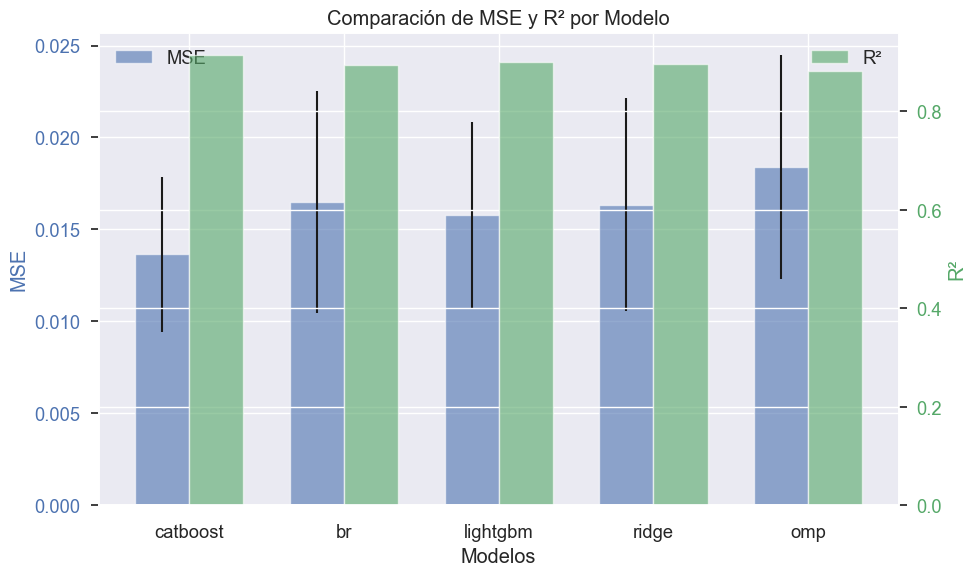

In [249]:
# Preparar los datos para el gráfico
model_names = list(models.keys())
mse_means = [mse_score[name].mean() for name in model_names]
mse_stds = [mse_score[name].std() for name in model_names]
r2_means = [r2_scores[name].mean() for name in model_names]

# Configuración del gráfico
x = np.arange(len(model_names))  # las posiciones en el eje x
width = 0.35  # ancho de las barras

fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de MSE
bars1 = ax1.bar(x - width/2, mse_means, width, yerr=mse_stds, label='MSE', color='b', alpha=0.6)
ax1.set_ylabel('MSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Crear un segundo eje y para R²
ax2 = ax1.twinx()  
bars2 = ax2.bar(x + width/2, r2_means, width, label='R²', color='g', alpha=0.6)
ax2.set_ylabel('R²', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Configuraciones adicionales
ax1.set_xlabel('Modelos')
ax1.set_title('Comparación de MSE y R² por Modelo')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

#### DANDO PESO A CADA MODELO DE ACUERDO AL MSE Y R2

In [250]:
# Parámetros de ponderación (ajustar si es necesario)
peso_mse = 0.5
peso_r2 = 0.5

# Normalización de mse y r2
mse_normalized = 1 - (mse_means - np.min(mse_means)) / (np.max(mse_means) - np.min(mse_means))
r2_normalized = (r2_means - np.min(r2_means)) / (np.max(r2_means) - np.min(r2_means))

# Calcular los pesos finales (combinando ambos valores)
pesos = peso_mse * mse_normalized + peso_r2 * r2_normalized

# Normalizar para que la suma de los pesos sea 100
pesos_normalizados = (pesos / np.sum(pesos)) * 100

# Mostrar los pesos asignados a cada modelo
for name, peso in zip(model_names, pesos_normalizados):
    print(f"Modelo: {name}, Peso: {peso:.2f}%")

Modelo: catboost, Peso: 41.74%
Modelo: br, Peso: 16.54%
Modelo: lightgbm, Peso: 23.59%
Modelo: ridge, Peso: 18.13%
Modelo: omp, Peso: 0.00%


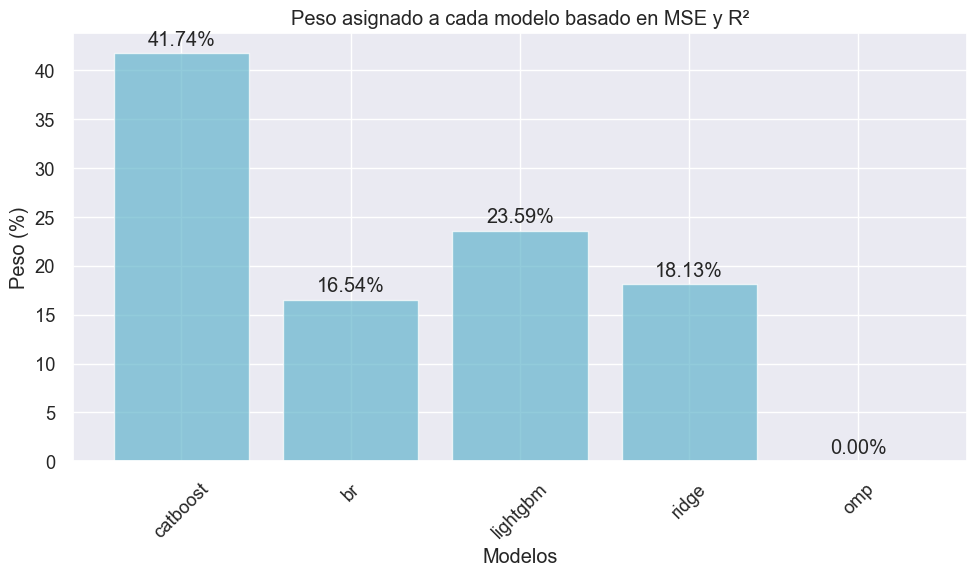

In [251]:
# Parámetros de ponderación (ajustar si es necesario)
peso_mse = 0.5
peso_r2 = 0.5

# Normalización de mse y r2
mse_normalized = 1 - (mse_means - np.min(mse_means)) / (np.max(mse_means) - np.min(mse_means))
r2_normalized = (r2_means - np.min(r2_means)) / (np.max(r2_means) - np.min(r2_means))

# Calcular los pesos finales (combinando ambos valores)
pesos = peso_mse * mse_normalized + peso_r2 * r2_normalized

# Normalizar para que la suma de los pesos sea 100
pesos_normalizados = (pesos / np.sum(pesos)) * 100

# Crear gráfico de barras para los pesos
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(model_names))
bars = ax.bar(x, pesos_normalizados, color='c', alpha=0.7)

# Añadir etiquetas y título
ax.set_xlabel('Modelos')
ax.set_ylabel('Peso (%)')
ax.set_title('Peso asignado a cada modelo basado en MSE y R²')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)

# Añadir los valores de peso en cada barra
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 puntos de distancia en el eje y
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [252]:
results

{'catboost': array([1.11996945, 1.09790685, 1.10747834, 1.15949442, 1.15227004,
        1.10770346, 1.12258794, 1.10140161, 1.12536584, 1.1327321 ]),
 'br': array([1.1236938 , 1.10465562, 1.12405625, 1.16848   , 1.1524003 ,
        1.12873658, 1.12522895, 1.10275044, 1.18802719, 1.13298601]),
 'lightgbm': array([1.12957546, 1.10531072, 1.11204297, 1.16955427, 1.16737513,
        1.11324252, 1.12723476, 1.10936854, 1.14745815, 1.14223858]),
 'ridge': array([1.12338036, 1.1053367 , 1.12412145, 1.16994036, 1.15545706,
        1.12173273, 1.1260853 , 1.1037994 , 1.18188318, 1.13358299]),
 'omp': array([1.13223077, 1.09725882, 1.12930056, 1.18311203, 1.15621703,
        1.15856033, 1.12668149, 1.11595193, 1.17872568, 1.15502105])}

In [253]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

----------
catboost
1.122691006008544
0.019668124463077117
----------
br
1.1351015144106285
0.025656641991269883
----------
lightgbm
1.1323401113019387
0.022377581009135113
----------
ridge
1.1345319533871139
0.02489861334742045
----------
omp
1.1433059679202837
0.02615240047297111


### COMBINANDO LAS PREDICIONES DE LOS MODELOS ELEGIDOS

In [254]:
total_predictions = (
    0.1 * np.exp(models['ridge'].predict(datos_predecir_final)) +
    0.1 * np.exp(models['omp'].predict(datos_predecir_final))+
    0.2 * np.exp(models['br'].predict(datos_predecir_final)) +
    0.2 * np.exp(models['lightgbm'].predict(datos_predecir_final)) +
    0.4 * np.exp(models['catboost'].predict(datos_predecir_final)) 
)

In [255]:
total_predictions

array([123468.19936849, 157567.32821914, 181564.12461881, ...,
       161020.13068363, 116375.51966252, 220231.31984029])

# EXPORTAR RESULTADO PREDECIDO

In [256]:
submission = pd.concat([datos_predecir_ids, pd.Series(total_predictions, name='SalePrice')], axis=1)
submission

,Id,SalePrice
0,1461,123468.199368
1,1462,157567.328219
2,1463,181564.124619
3,1464,192826.224827
4,1465,191209.435563
...,...,...
1454,2915,86026.766329
1455,2916,81279.515998
1456,2917,161020.130684
1457,2918,116375.519663


In [257]:
submission.to_csv('./submission_final.csv', index=False, header=True)